<a href="https://colab.research.google.com/github/hunnurjirao/DCGAN/blob/master/model.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Download the Datasets

In [ ]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

In [113]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [137]:
import os
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


### Import required packages

In [138]:
import random
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [139]:
img_size=64
batch_size=128
input_latent=100

### Load the Data

In [140]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.ToPILImage(),
     transforms.Scale(size=(img_size, img_size), interpolation=Image.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder(root='./data_faces',transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


### Training Images

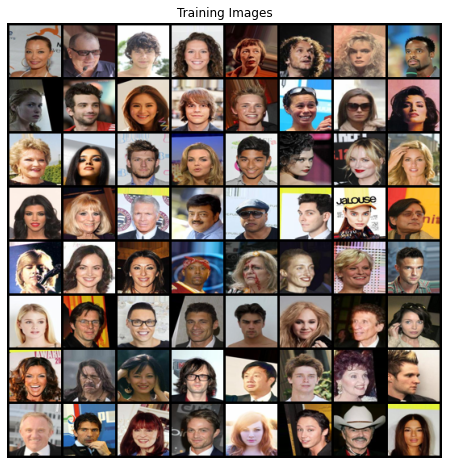

In [141]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=3, normalize=True).cpu(),(1,2,0)))

In [142]:
def initialize_weights(w):
    classname = w.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(w.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(w.weight.data, 1.0, 0.02)
        nn.init.constant_(w.bias.data, 0)

### Generator

In [143]:
Gen = nn.Sequential(

            nn.ConvTranspose2d( input_latent,512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()

        )

In [144]:
Gen=Gen.to(device)

Gen.apply(initialize_weights)
print(Gen)

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)


### Discriminator

In [145]:
Dis = nn.Sequential(

            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )



In [146]:
Dis=Dis.to(device)

Dis.apply(initialize_weights)
print(Dis)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Sigmoid()
)


### Loss functions and Optimizer

In [147]:
criterion = nn.BCELoss()

Gen_optimizer = torch.optim.Adam(Gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
Dis_optimizer = torch.optim.Adam(Dis.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Training

In [148]:
sample_dir='/content/sample_data/images'
grid_size=64 # 8 x 8
fixed_noise = torch.randn(grid_size, input_latent, 1, 1, device=device)
num_epochs=5

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    
    for i, data in enumerate(dataloader, 0):

        
        #<==========================================================>#
        
        
        
        Dis.zero_grad()
        
        real_cpu = data[0].to(device)

        b_size = real_cpu.size(0)

       
        label = torch.full((b_size,), 1, device=device)
        
        output = Dis(real_cpu).view(-1)
        
        errD_real = criterion(output, label)
        
        errD_real.backward()

        D_x = output.mean().item()

        
        noise = torch.randn(b_size, input_latent, 1, 1, device=device)

        fake = Gen(noise)
        label.fill_(0)

        output = Dis(fake.detach()).view(-1)

        errD_fake = criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        
        
        Dis_optimizer.step()

        #<==========================================================>#

        Gen.zero_grad()
        label.fill_(1)  

        output = Dis(fake).view(-1)

        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()

        Gen_optimizer.step()

        if i % 200 == 0:
            print('[%d/%d][%d/%d]      Loss_D: %.4f      Loss_G: %.4f      D(x): %.4f      D(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = Gen(fixed_noise).detach().cpu()
            img_list.append( torchvision.utils.make_grid(fake, padding=2, normalize=True))



           
            torchvision.utils.save_image(fake, os.path.join(sample_dir, 'fake_images-{}.png'.format(iters+1)))
        iters += 1



Starting Training Loop...
[0/5][0/1583]      Loss_D: 2.0589      Loss_G: 6.5166      D(x): 0.6573      D(G(z)): 0.7317 / 0.0025
[0/5][200/1583]      Loss_D: 0.0135      Loss_G: 38.1359      D(x): 0.9900      D(G(z)): 0.0000 / 0.0000
[0/5][400/1583]      Loss_D: 0.9048      Loss_G: 7.0662      D(x): 0.9291      D(G(z)): 0.5034 / 0.0017
[0/5][600/1583]      Loss_D: 0.5234      Loss_G: 6.1530      D(x): 0.9481      D(G(z)): 0.3243 / 0.0051
[0/5][800/1583]      Loss_D: 0.4377      Loss_G: 4.6713      D(x): 0.8510      D(G(z)): 0.1908 / 0.0186
[0/5][1000/1583]      Loss_D: 0.5725      Loss_G: 4.9134      D(x): 0.8329      D(G(z)): 0.2680 / 0.0119
[0/5][1200/1583]      Loss_D: 0.5106      Loss_G: 5.0818      D(x): 0.8627      D(G(z)): 0.2369 / 0.0125
[0/5][1400/1583]      Loss_D: 0.5799      Loss_G: 3.9443      D(x): 0.8293      D(G(z)): 0.2716 / 0.0314
[1/5][0/1583]      Loss_D: 0.7759      Loss_G: 6.2600      D(x): 0.9478      D(G(z)): 0.4534 / 0.0044
[1/5][200/1583]      Loss_D: 0.7075   

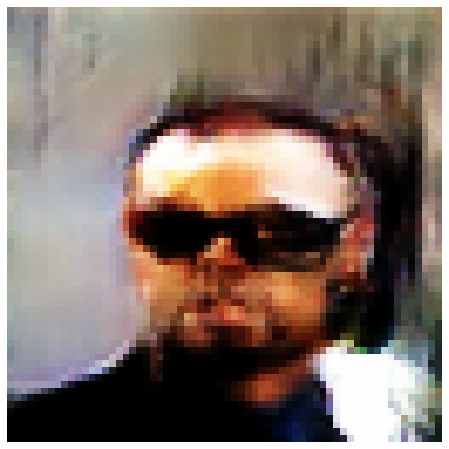

In [157]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
#ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_list]
plt.imshow(np.transpose(img_list[15],(1,2,0)), animated=True)